## Rotation Correction Model Training

Some of the images in the training set are rotated in multiples of 90 degrees, which need to be corrected before being used in training or inference.  Detecting and correcting this needs to be much faster than the general classification task, but should it should be doable with a small dataset, since all the images are of buildings.

Steps we are going to follow for this:
1. Make a copy of the training data but with all the rotated images fixed
2. Resize all images to (64,64), which is satisfactory for determining orientation
2. Add a fourth channel that contains edges of the image as detected via Canny edge detection
4. Create a small CNN that has four outputs: one for each possible orientation
5. Unsupervised training: use cv2 to rotate images and then train the CNN to detect the rotation

In [1]:
import argparse
import cv2
import os
import platform
import sys
from collections import defaultdict

import ipywidgets as widgets
from IPython.display import display
from IPython.core.debugger import set_trace
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
 
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
%matplotlib inline
 
print("OS Type: %s" % os.name)
print("OS Name: %s" % platform.system())
print("OS Release: %s" % platform.release())
print(f'Using Python={sys.version}')
print(f'Using Tensorflow={tf.__version__}')
print(f'Using Keras={keras.__version__}')
print("GPU Available: ", tf.test.is_gpu_available())

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


OS Type: posix
OS Name: Linux
OS Release: 4.15.0-50-generic
Using Python=3.7.2 (default, Mar 30 2019, 15:56:42) 
[GCC 5.4.0 20160609]
Using Tensorflow=2.0.0-rc2
Using Keras=2.2.4-tf
GPU Available:  True


In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
from load_and_preprocess_data import *
from image_utilities import ImageUtilities

In [6]:
train_folder = 'train_rotate' # Only correct-orientation images

In [8]:
train_info = TrainDataInfo('train_rotate')
train_spl, test_spl = train_info.traintest_splits[0]

In [56]:

def input_generator_train_rotation(all_train_info, file_map):
    """
    The train_info object has all train and test samples/filenames.  We use it just for the
    sampling probabilities.
    """
    
    def out_generator():
        while(True):
            img_path = all_train_info.sample_filename()
            img = ImageUtilities.load_image(full)
            img = cv2.resize(img, (64, 64))
            num_clicks = np.random.choice(4)
            img = rotate_image(img, clicks=num_clicks)
            ans = np.zeros(shape=(4,), dtype='float32')
            ans[num_clicks] = 1.0
            yield (img, ans)
        
    return out_generator
        
def get_rotate_dataset(all_train_info, file_map, batch_size=32):
    """
    The train_info object has all train and test samples/filenames.  We use it just for the
    sampling probabilities.  file_map has the actual data we want to sample from
    """
    test_dataset = tf.data.Dataset.from_generator( 
        input_generator_train_rotation(all_train_info, file_map)
        (tf.float64, tf.float64), 
        (tf.TensorShape([64,64,3]), tf.TensorShape([4])))

    if batch_size:
        test_dataset = test_dataset.batch(32)
        
    return test_dataset

def load_all_images_one_rotation(file_map, clicks=0):
    all_imgs = []
    for country,fn_list in file_map.items():
        for fullpath in fn_list:
            orig_img = ImageUtilities.load_image(fullpath)
            resz_img = cv2.resize(orig_img, (64, 64))
            rotated = ImageUtilities.rotate_image_90deg(resz_img, clicks=clicks)
            all_imgs.append(rotated)
            
    out = np.stack(all_imgs)
    print(f'Full dataset for rotation, {clicks} clicks: {out.shape}')
    return (out, [clicks] * out.shape[0])

def load_all_images_all_rotations(file_map):
    all_rotations = [load_all_images_one_rotation(file_map, i) for i in range(4)]
    all_imgs = np.concatenate([i[0] for i in all_rotations], axis=0)
    all_lbls = np.concatenate([i[1] for i in all_rotations], axis=0)
    print(f'Combined dataset shape: imgs~{all_imgs.shape}, lbls~{all_lbls.shape}')
    return (all_imgs, labels)
    

Full dataset for rotation, 0 clicks: (143, 64, 64, 3)
Full dataset for rotation, 1 clicks: (143, 64, 64, 3)
Full dataset for rotation, 2 clicks: (143, 64, 64, 3)
Full dataset for rotation, 3 clicks: (143, 64, 64, 3)
Combined dataset shape: imgs~(572, 64, 64, 3), lbls~(572,)
(572, 64, 64, 3)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

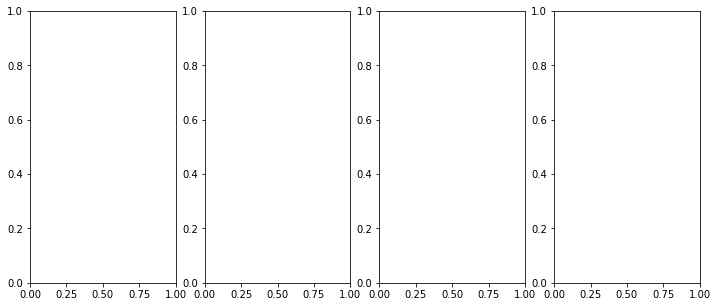

In [62]:
test_imgs, test_labels = load_all_images_all_rotations(test_spl)
print(test_imgs.shape)
n_img = test_imgs.shape[0] / 4
fig,axs = plt.subplots(1, 4, figsize=(12, 5))
for i in range(4):
    axs[i].imshow(test_imgs[i*n_img])
    axs[i].set_title(f'Rotation 90deg clicks: {i}')


In [38]:
trainset = np.concatenate([load_all_rotate_set(train_spl, i) for i in range(4)], axis=0)
train_ct = int(trainsets.shape[0] / 4)
labels = np.array([0] * train_ct + [1] * train_ct + [2] * train_ct + [3] * train_ct)
print(f'Training set: {trainset.shape}, labels: {labels.shape}')

Full dataset for rotation testing: (549, 64, 64, 3)
Full dataset for rotation testing: (549, 64, 64, 3)
Full dataset for rotation testing: (549, 64, 64, 3)
Full dataset for rotation testing: (549, 64, 64, 3)
Training set: (2196, 64, 64, 3), labels: (2196,)


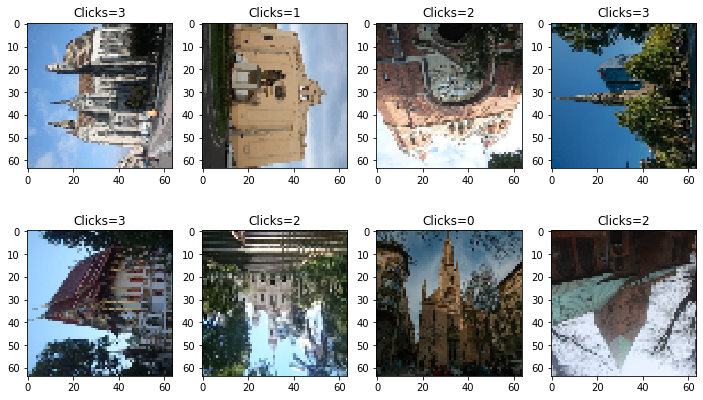

In [42]:
fig,axs = plt.subplots(2, 4, figsize=(12,7))
for r in range(2):
    for c in range(4):
        i = np.random.choice(trainsets.shape[0])
        axs[r][c].imshow(trainset[i])
        axs[r][c].set_title(f'Clicks={labels[i]}')
    

## Attempt CNN Solution
Multi-class classification c

In [26]:
def BN(layer):
    return L.BatchNormalization()(layer)

def create_rotate_detect_model(img_size=(64,64,3)):
    x = inputs = L.Input(shape=img_size)
    
    # 64 x 64 x 3
    
    x = BN(L.Conv2D(32, kernel_size=(1,1), strides=1, padding='valid', activation='relu')(x))
    x = BN(L.Conv2D(32, kernel_size=(3,3), strides=2, padding='valid', activation='relu')(x))
    
    # 32 x 32 x 32
    
    x = BN(L.Conv2D(64, kernel_size=(3,3), strides=1, padding='valid', activation='relu')(x))
    x = BN(L.Conv2D(64, kernel_size=(3,3), strides=2, padding='valid', activation='relu')(x))
    
    # 16 x 16 x 64
    
    x = BN(L.Conv2D(96, kernel_size=(3,3), strides=2, padding='valid', activation='relu')(x))
    x = L.GlobalMaxPool2D()(x)
    
    # (96,)
    
    x = L.Dense(32, activation='tanh')(x)
    x = L.Dropout(0.15)(x)
    x = predictions = L.Dense(4, activation='sigmoid')(x)

    # This creates a model
    return keras.Model(inputs=inputs, outputs=predictions) 

test_model = create_rotate_detect_model()
test_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        128       
_________________________________________________________________
batch_normalization_15 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 31, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 29, 29, 64)        256 

In [23]:
test_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy')

In [ ]:
hist = test_model.fit_generator(input_generator_train_rotation(train_info, file_map))